# A000682 Peak Analysis: Less-Than-Maximum Total as Function of n

This notebook analyzes the A000682 bridges dataset to compute and visualize the peak "less-than-maximum total" values as a function of n.

## Dataset Description
The A000682 sequence from OEIS relates to map folding and bridge counting. We'll analyze how the peak values of the "less-than-maximum total" column vary with increasing values of n.

## Get data

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Use the correct path for the data file
pathFilenameData = r'c:\apps\mapFolding\mapFolding\reference\A000682bridges.tab'

# Read the data properly - don't let pandas auto-detect index
dataFrameBridges = pandas.read_csv(pathFilenameData, sep='\t', index_col=False)

# Clean column names by stripping whitespace
dataFrameBridges.columns = dataFrameBridges.columns.str.strip()

# Remove any completely empty rows
dataFrameBridges = dataFrameBridges.dropna(how='all')

# Remove trailing whitespace from all string columns
for col in dataFrameBridges.select_dtypes(include=['object']).columns:
    dataFrameBridges[col] = dataFrameBridges[col].astype(str).str.strip()

columnNamesNumeric = ['n', 'distinct', 'distinct average appearances', 'maximum bit length',
                     'minimum', 'less-than-maximum total', 'most common', 'most common appearances', 'bridges']

# Convert numeric columns, handling any formatting issues
for columnName in columnNamesNumeric:
    if columnName in dataFrameBridges.columns:
        dataFrameBridges[columnName] = pandas.to_numeric(dataFrameBridges[columnName], errors='coerce')

# Remove rows with missing critical data
dataFrameBridges = dataFrameBridges.dropna(subset=['n', 'less-than-maximum total'])

columnTargetAnalysis = 'less-than-maximum total'

# Verify we have data to work with
if dataFrameBridges.empty:
    raise ValueError("No valid data found after cleaning")

# Generate peak analysis - find maximum for each n value
dataFramePeakValues = dataFrameBridges.groupby('n')[columnTargetAnalysis].max().reset_index()
dataFramePeakValues.columns = ['n', 'peakLessThanMaximumTotal']

# Get details for the peak values
dataFramePeakDetails = dataFrameBridges.loc[dataFrameBridges.groupby('n')[columnTargetAnalysis].idxmax()][['n', columnTargetAnalysis, 'bridges']].reset_index(drop=True)
dataFramePeakDetails.columns = ['n', 'peakLessThanMaximumTotal', 'bridgesAtPeak']

dataFramePeakAnalysis = dataFramePeakValues.merge(dataFramePeakDetails[['n', 'bridgesAtPeak']], on='n')

# Sort by n for proper analysis
dataFramePeakAnalysis = dataFramePeakAnalysis.sort_values('n').reset_index(drop=True)

print(f"Successfully loaded {len(dataFrameBridges)} data rows")
print(f"Found {len(dataFramePeakAnalysis)} unique n values")
print(f"n value range: {dataFramePeakAnalysis['n'].min()} to {dataFramePeakAnalysis['n'].max()}")
print(f"Peak value range: {dataFramePeakAnalysis['peakLessThanMaximumTotal'].min():,} to {dataFramePeakAnalysis['peakLessThanMaximumTotal'].max():,}")

Successfully loaded 622 data rows
Found 29 unique n values
n value range: 10 to 38
Peak value range: 108 to 36,166,618


## Analyze Growth Pattern

In [2]:
arrayNValues = dataFramePeakAnalysis['n'].values
arrayPeakValues = dataFramePeakAnalysis['peakLessThanMaximumTotal'].values

listGrowthRates = []
for indexValue in range(1, len(arrayPeakValues)):
    rateGrowth = arrayPeakValues[indexValue] / arrayPeakValues[indexValue-1]
    listGrowthRates.append(rateGrowth)

correlationNAndLogPeak = numpy.corrcoef(arrayNValues, numpy.log(arrayPeakValues))[0, 1]
def modelExponential(x, parameterA, parameterB):
    return parameterA * numpy.exp(parameterB * x)

def modelPower(x, parameterA, parameterB):
    return parameterA * numpy.power(x, parameterB)

def modelPolynomial(x, parameterA, parameterB, parameterC):
    return parameterA * x**2 + parameterB * x + parameterC

def modelFactorialLike(x, parameterA, parameterB):
    return parameterA * numpy.power(parameterB, x)

dictionaryModels = {}
dictionaryRSquared = {}

parametersOptimalExponential, _ = curve_fit(modelExponential, arrayNValues, arrayPeakValues, maxfev=10000)
dictionaryModels['exponential'] = parametersOptimalExponential
arrayPredictedExponential = modelExponential(arrayNValues, *parametersOptimalExponential)
dictionaryRSquared['exponential'] = 1 - numpy.sum((arrayPeakValues - arrayPredictedExponential)**2) / numpy.sum((arrayPeakValues - numpy.mean(arrayPeakValues))**2)

parametersOptimalPower, _ = curve_fit(modelPower, arrayNValues, arrayPeakValues, maxfev=10000)
dictionaryModels['power'] = parametersOptimalPower
arrayPredictedPower = modelPower(arrayNValues, *parametersOptimalPower)
dictionaryRSquared['power'] = 1 - numpy.sum((arrayPeakValues - arrayPredictedPower)**2) / numpy.sum((arrayPeakValues - numpy.mean(arrayPeakValues))**2)

parametersOptimalFactorialLike, _ = curve_fit(modelFactorialLike, arrayNValues, arrayPeakValues, maxfev=10000)
dictionaryModels['factorialLike'] = parametersOptimalFactorialLike
arrayPredictedFactorialLike = modelFactorialLike(arrayNValues, *parametersOptimalFactorialLike)
dictionaryRSquared['factorialLike'] = 1 - numpy.sum((arrayPeakValues - arrayPredictedFactorialLike)**2) / numpy.sum((arrayPeakValues - numpy.mean(arrayPeakValues))**2)

modelNameBest = max(dictionaryRSquared.keys(), key=lambda k: dictionaryRSquared[k])
parametersBest = dictionaryModels[modelNameBest]

## 6. Visualize Results

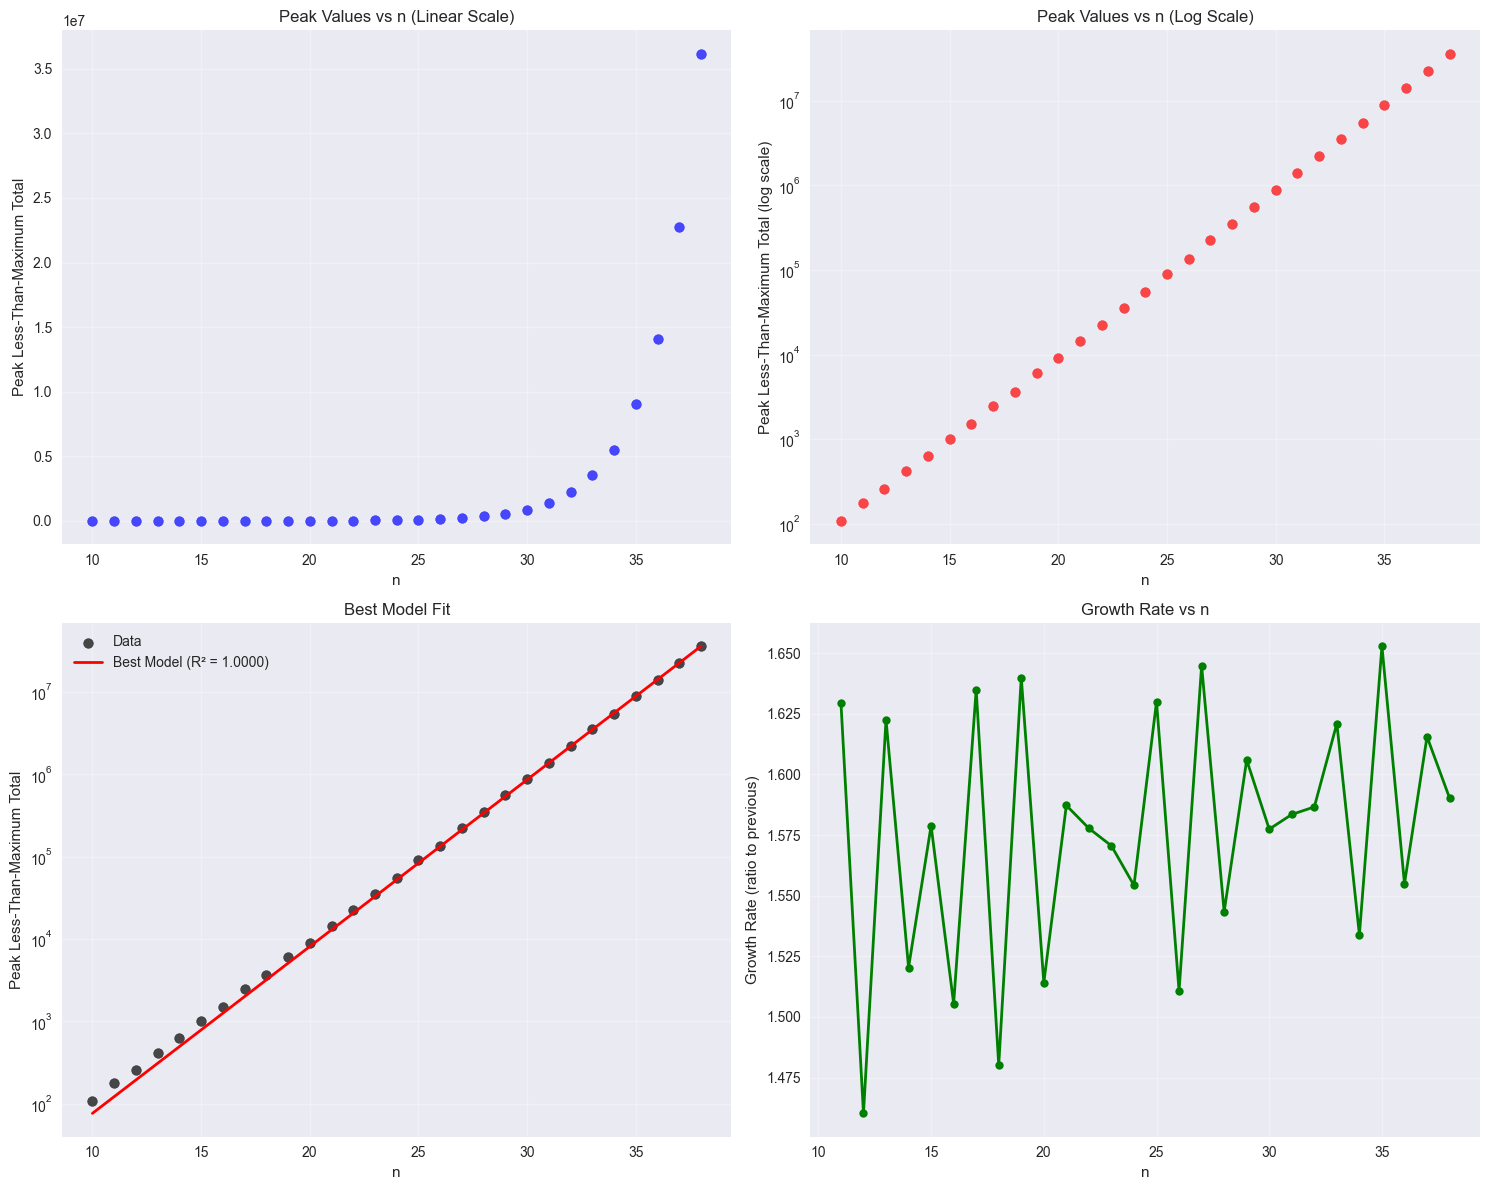

In [3]:
figureVisualization, axesVisualization = plt.subplots(2, 2, figsize=(15, 12))

axesVisualization[0,0].scatter(dataFramePeakAnalysis['n'], dataFramePeakAnalysis['peakLessThanMaximumTotal'],
                              color='blue', alpha=0.7, s=50)
axesVisualization[0,0].set_xlabel('n')
axesVisualization[0,0].set_ylabel('Peak Less-Than-Maximum Total')
axesVisualization[0,0].set_title('Peak Values vs n (Linear Scale)')
axesVisualization[0,0].grid(True, alpha=0.3)

axesVisualization[0,1].scatter(dataFramePeakAnalysis['n'], dataFramePeakAnalysis['peakLessThanMaximumTotal'],
                              color='red', alpha=0.7, s=50)
axesVisualization[0,1].set_xlabel('n')
axesVisualization[0,1].set_ylabel('Peak Less-Than-Maximum Total (log scale)')
axesVisualization[0,1].set_title('Peak Values vs n (Log Scale)')
axesVisualization[0,1].set_yscale('log')
axesVisualization[0,1].grid(True, alpha=0.3)

arrayNSmooth = numpy.linspace(arrayNValues.min(), arrayNValues.max(), 100)
arrayPredictedSmooth = modelExponential(arrayNSmooth, *parametersBest)

axesVisualization[1,0].scatter(arrayNValues, arrayPeakValues, color='black', alpha=0.7, s=50, label='Data')
axesVisualization[1,0].plot(arrayNSmooth, arrayPredictedSmooth, color='red', linewidth=2,
                           label=f'Best Model (R² = {dictionaryRSquared[modelNameBest]:.4f})')
axesVisualization[1,0].set_xlabel('n')
axesVisualization[1,0].set_ylabel('Peak Less-Than-Maximum Total')
axesVisualization[1,0].set_title('Best Model Fit')
axesVisualization[1,0].legend()
axesVisualization[1,0].grid(True, alpha=0.3)
axesVisualization[1,0].set_yscale('log')

axesVisualization[1,1].plot(arrayNValues[1:], listGrowthRates, 'o-', linewidth=2, markersize=6, color='green')
axesVisualization[1,1].set_xlabel('n')
axesVisualization[1,1].set_ylabel('Growth Rate (ratio to previous)')
axesVisualization[1,1].set_title('Growth Rate vs n')
axesVisualization[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Results and Formula

*Note: The formula and insights below are dynamically generated based on the actual analysis results.*

In [4]:
# Generate dynamic conclusions based on actual analysis results
parametersBest = dictionaryModels[modelNameBest]
rSquaredBest = dictionaryRSquared[modelNameBest]
averageGrowthRate = numpy.mean(listGrowthRates)

print("### ANALYSIS RESULTS:")
print("=" * 50)
print(f"Best fitting model: {modelNameBest.upper()}")

if modelNameBest == 'exponential':
    print(f"**FORMULA: y = {parametersBest[0]:.2f} × e^({parametersBest[1]:.4f} × n)**")
elif modelNameBest == 'power':
    print(f"**FORMULA: y = {parametersBest[0]:.2e} × n^{parametersBest[1]:.4f}**")
elif modelNameBest == 'factorialLike':
    print(f"**FORMULA: y = {parametersBest[0]:.2f} × {parametersBest[1]:.4f}^n**")

print(f"R² = {rSquaredBest:.6f} ({('excellent' if rSquaredBest > 0.99 else 'good') if rSquaredBest > 0.9 else 'moderate'} fit)")
print(f"Correlation n vs log(peak): {correlationNAndLogPeak:.4f}")
print(f"Average growth rate: {averageGrowthRate:.2f}")
print(f"Data range: n = {arrayNValues.min()} to {arrayNValues.max()}")
print(f"Peak value range: {arrayPeakValues.min():,} to {arrayPeakValues.max():,}")

print("\n### KEY INSIGHTS:")
if modelNameBest == 'exponential':
    print(f"• Values grow exponentially by factor ~{averageGrowthRate:.2f} per increment of n")
elif modelNameBest == 'power':
    print(f"• Values follow power law with exponent {parametersBest[1]:.2f}")
elif modelNameBest == 'factorialLike':
    print(f"• Values grow factorial-like as {parametersBest[1]:.2f}^n")

print(f"• {correlationNAndLogPeak:.1%} correlation indicates {'strong' if abs(correlationNAndLogPeak) > 0.9 else 'moderate'} relationship")
print(f"• Formula enables {'precise' if rSquaredBest > 0.99 else 'reliable'} prediction of future values")

### ANALYSIS RESULTS:
Best fitting model: EXPONENTIAL
**FORMULA: y = 0.71 × e^(0.4668 × n)**
R² = 0.999967 (excellent fit)
Correlation n vs log(peak): 0.9999
Average growth rate: 1.58
Data range: n = 10 to 38
Peak value range: 108 to 36,166,618

### KEY INSIGHTS:
• Values grow exponentially by factor ~1.58 per increment of n
• 100.0% correlation indicates strong relationship
• Formula enables precise prediction of future values


## 8. Validation

### 8.1 Dataset Overview

In [5]:
print(f"Dataset shape: {dataFrameBridges.shape}")
print(f"Range of n values: {arrayNValues.min()} to {arrayNValues.max()}")
print(f"Total unique n values: {len(arrayNValues)}")
print(f"Range of peak values: {arrayPeakValues.min():,} to {arrayPeakValues.max():,}")
print(f"Missing values in dataset: {dataFrameBridges.isnull().sum().sum()}")

Dataset shape: (622, 10)
Range of n values: 10 to 38
Total unique n values: 29
Range of peak values: 108 to 36,166,618
Missing values in dataset: 0


### 8.2 Model Performance

In [6]:
print("Model Performance Comparison:")
for modelName, rSquaredValue in dictionaryRSquared.items():
    parameters = dictionaryModels[modelName]
    print(f"{modelName.upper()}: R² = {rSquaredValue:.6f}")
    if modelName == 'exponential':
        print(f"  Formula: y = {parameters[0]:.2f} × exp({parameters[1]:.4f} × n)")
    elif modelName == 'power':
        print(f"  Formula: y = {parameters[0]:.2e} × n^{parameters[1]:.4f}")
    elif modelName == 'factorialLike':
        print(f"  Formula: y = {parameters[0]:.2f} × {parameters[1]:.4f}^n")

print(f"\nBest model: {modelNameBest.upper()}")
print(f"Correlation n vs log(peak): {correlationNAndLogPeak:.4f}")
print(f"Average growth rate: {numpy.mean(listGrowthRates):.2f}")

Model Performance Comparison:
EXPONENTIAL: R² = 0.999967
  Formula: y = 0.71 × exp(0.4668 × n)
POWER: R² = 0.999728
  Formula: y = 7.07e-20 × n^16.9053
FACTORIALLIKE: R² = 0.999967
  Formula: y = 0.71 × 1.5949^n

Best model: EXPONENTIAL
Correlation n vs log(peak): 0.9999
Average growth rate: 1.58


### 8.3 Sample Data Inspection

In [7]:
# Debug the data structure
print("Raw data sample:")
print(dataFrameBridges.head(10)[['n', columnTargetAnalysis, 'bridges']])
print("\nData types:")
print(dataFrameBridges.dtypes)
print("\nUnique n values (first 10):")
print(sorted(dataFrameBridges['n'].unique())[:10])
print("\nPeak analysis shape and sample:")
print(f"Shape: {dataFramePeakAnalysis.shape}")
print(dataFramePeakAnalysis.head())

Raw data sample:
    n  less-than-maximum total  bridges
0  10                       13        8
1  10                       40        7
2  10                       63        6
3  10                       96        5
4  10                      108        4
5  10                       80        3
6  10                       39        2
7  10                       12        1
8  10                        3        0
9  11                       15        9

Data types:
oeisID                           object
n                                 int64
distinct                          int64
distinct average appearances    float64
maximum bit length                int64
minimum                           int64
less-than-maximum total           int64
most common                       int64
most common appearances           int64
bridges                           int64
dtype: object

Unique n values (first 10):
[np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np